In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from helper_functions import linear_model_summary

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# This is not good practice, but is appropriate here for a beginners class.
# This allows us to not fuss with image sizes later in the presentation.
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# Linear and Logistic Regression

## Loading and Inspecting the Data

For our example we will use a dataset dataset about various specimens of single species of insect collected across two continents.  The data was acquired from this question on CrossValidated, a statistics/data science question and answer site:

[Multiple regression, full and restricted model](http://stats.stackexchange.com/q/267034/74500)

We chose this dataset because it is small enough to be accessible, but has some interesting features for us to discover!

We will be interested in explaining how the insects wing span varies, as influenced by the other measurements in our dataset.

We'd like to load the `insects` data into python.  Our first step is to take a quick look at the raw data.

In [2]:
!head ./insects.csv

continent	latitude	wingsize	sex
1	40.5	941.111111111	0
1	42.0	924.444444444	0
1	43.6	924.204444444	0
1	45.7	915.217777778	0
1	45.9	905.471111111	0
1	47.4	896.004444444	0
1	50.0	913.0	0
1	51.8	916.44	0
1	53.8	933.417777778	0


`head` is actually a small command line program that displays the first 10 lines of a file.  We're using it here to inform our strategy for reading the data into python.

**Discussion:** How would you describe this dataset?  How many variables are there?  How would you describe these variables?

It looks like there are four columns in our dataset:

```
continent, latitude, wingsize, and sex
```

Each data element is separated from the next by a tab character, this type of format is often called "tab separated data".  Tab separated data can be read into python using the `read_csv` function in the `pandas` library.

In [3]:
insects = pd.read_csv('./insects.csv', sep='\t')

Now we have the data in a python object:

In [35]:
insects.head()

,continent,latitude,wingsize,sex
0,1,40.5,941.111111,0
1,1,42.0,924.444444,0
2,1,43.6,924.204444,0
3,1,45.7,915.217778,0
4,1,45.9,905.471111,0


We've got our four columns `continent, latitude, wingsize, and sex`.  

We can see some short descriptions of their qualities using `info`:

In [5]:
insects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
continent    42 non-null int64
latitude     42 non-null float64
wingsize     42 non-null float64
sex          42 non-null int64
dtypes: float64(2), int64(2)
memory usage: 1.4 KB


## Looking at the Data

We can get a first feel for how the quantities in our data are spread out using **histograms**:

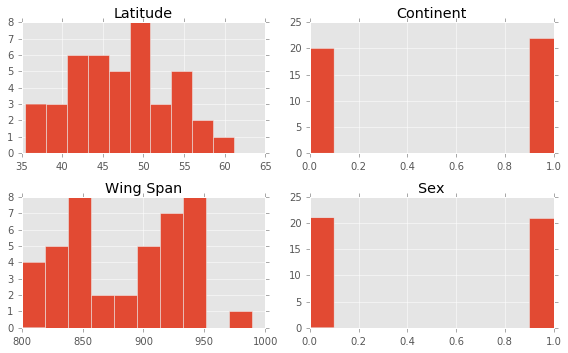

In [6]:
column_names = {
    "continent": "Continent",
    "latitude": "Latitude",
    "wingsize": "Wing Span",
    "sex": "Sex"
}

fig, axs = plt.subplots(2, 2)
for ax, (column, name) in zip(axs.flatten(), column_names.iteritems()):
    ax.hist(insects[column])
    ax.set_title(name)

fig.tight_layout()

**Discussion:** What have you learned form the data from these histograms?  How do they help you describe the data?

Some observations:

  - `continent` and `sex` take only two values.  There are two continents represented in the data, labeled zero and one, and there are two sexes (probably Male and Female), also labeled zero and one.
  
These zero/one columns are called **binary** or **indicator variables**, they measure a specific yes/no condition.

  - The values of `wingspan` cluster into two distinct groups.  This is very interesting, and worthy of investigation.

## Scatterplots

Histograms are useful, but limited, as they do not reveal anything about the *relationships between the columns in our data*.  To rectify this we turn to uncountably the most effective and flexible visualization, the **scatterplot**.

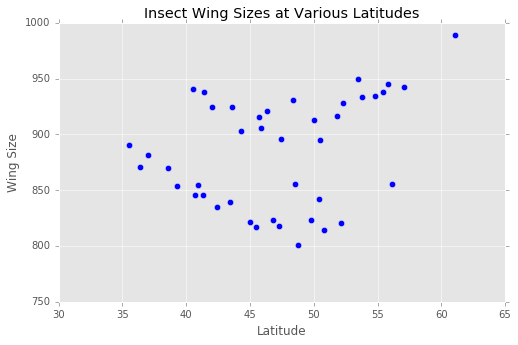

In [7]:
fig, ax = plt.subplots()

ax.scatter(insects.latitude, insects.wingsize, s=40)
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Insect Wing Sizes at Various Latitudes")

Here we have a scatterplot of `wingsize` against `latitude`.

**Discussion:** What patterns do you see in the scatterplot.  Can you form any hypothesis about the data?

Here are some thoughts:
    
  - The most prominent feature of this data is the two bands.  There seem to be two very well defined elongated clusters of data, with the average wingsize in one cluster much greater than in the other.
  - Within each cluster there is noticeable tendency for wingsize first decrease, and then increase as latitude varies.

## Linear Regression

This leads to a few questions we may wish to answer with the data.

  1. Are the two clusters associated with one of the other two variables in the dataset, continent or sex?
  2. Is the increase of wing size as latitude increases real or illusory?
  
Let's answer each of these questions.

### Are The Two Clusters Associated With Either Continent or Sex?

We can discover if the two clusters in the data are associated with either `continent` or `sex` through a well chosen visualization.  Let's make the same scatterplot from before, but color each point either red or blue, according to the value of `continent` or `sex`.

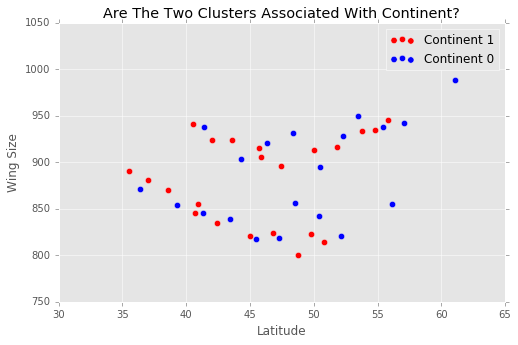

In [8]:
fig, ax = plt.subplots()

continent_boolean = insects.continent.astype(bool)
ax.scatter(insects.latitude[continent_boolean], 
           insects.wingsize[continent_boolean], 
           s=40, c="red", label="Continent 1")
ax.scatter(insects.latitude[~continent_boolean], 
           insects.wingsize[~continent_boolean],
           s=40, c="blue", label="Continent 0")
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Are The Two Clusters Associated With Continent?")
ax.legend()

The values of continent seem scattered randomly across the two clusters, so it does **not** seem like continent is associated with the clusters.

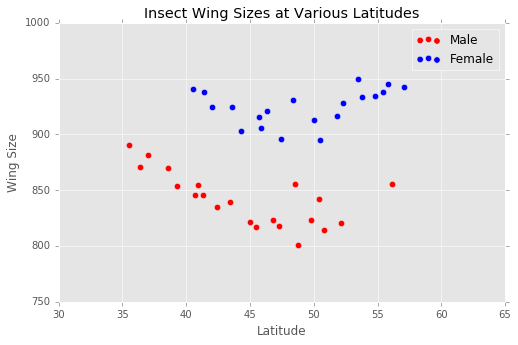

In [9]:
fig, ax = plt.subplots()

sex_boolean = insects.sex.astype(bool)
ax.scatter(insects.latitude[sex_boolean], 
           insects.wingsize[sex_boolean],
           s=40, c="red", label="Male")
ax.scatter(insects.latitude[~sex_boolean], 
           insects.wingsize[~sex_boolean],
           s=40, c="blue", label="Female")
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Insect Wing Sizes at Various Latitudes")
ax.legend()

There we go!

This is pretty definitive, the cluster of the larger insects are all female, and the cluster of smaller insects are all male.  This seems like enough evidence to conclude that the sex of the insect causes the data to cluster into two groups.

### Is An Increasing Latitude Associated With an Increasing Wing Size?

This question is a little more sophisticated, and we need some new technology to answer it.

The idea is to create an equation:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} $$

Then we can look at the number $b$, which tells us how we should expect `wingspan` to change as `latitude` changes.  If we find that $b > 0$, that's evidence that an increasing latitude is associated with an increasing wingspan.

I'll skip the technicalities, but the basic tool for creating equations like this is called **linear regression**.

In [10]:
linear_model = smf.ols(formula='wingsize ~ latitude', data=insects)
insects_model = linear_model.fit()
linear_model_summary(insects_model)

              Linear Model Summary             
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept                765.20           56.28
latitude                   2.54            1.18


The linear regression has attempted to estimate the equation we are after, and it has returned:

$$ \text{Wing Span} \approx 765.20+ 2.54 \times \text{Latitude} $$

So we can expect an on average increase of 1.88 wingspan for every increase in one latitude.

One way we can visualize this is to look at the equation as the equation for a line. If we *know* the latitude that we find an insect, we can *predict* the wing span using the equation.  If we plot the latitudes verses the predictions, we get a line.

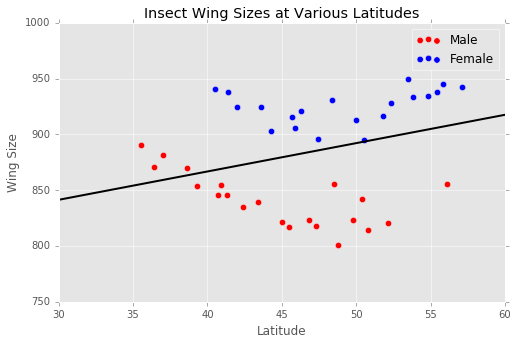

In [11]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
sex_boolean = insects.sex.astype(bool)
ax.scatter(insects.latitude[sex_boolean], 
           insects.wingsize[sex_boolean],
           s=40, c="red", label="Male")
ax.scatter(insects.latitude[~sex_boolean], 
           insects.wingsize[~sex_boolean],
           s=40, c="blue", label="Female")

# Make a linea graph of the predictions.
x = np.linspace(30, 60, num=250)
ax.plot(x, insects_model.params[0] + insects_model.params[1] * x,
       linewidth=2, c="black")

ax.set_xlim(30, 60)
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Insect Wing Sizes at Various Latitudes")
ax.legend()

This plot elucidates two serious flaws in our model:

  - It has no knowledge of the sex of the insect, so the fit line attemps to bisect the two clusters of data.
  - It cannot account for the curvature in the data points.  The model attempts to fit a line to data that does not have a linear shape.

### How is the Line Determined?

Before we make the model more complicated, it would be good to know *how* our model is determining the line to fit to the data.

We can think of the fitted line as a *prediction*.  If we were to collect a new insect at a certain latitude, the y-coordinate of the line would be our best estiamte for the wing span of that insect.

A good strategy for drawing the line would seem to be:

> Try to draw the line that minimizes the dissimilarity between the predictions and the actual $y$ data.

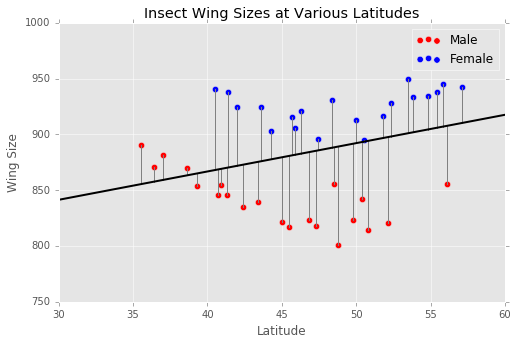

In [12]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
sex_boolean = insects.sex.astype(bool)
ax.scatter(insects.latitude[sex_boolean], 
           insects.wingsize[sex_boolean],
           s=40, c="red", label="Male")
ax.scatter(insects.latitude[~sex_boolean], 
           insects.wingsize[~sex_boolean],
           s=40, c="blue", label="Female")

# Draw a bunch of vertial lines to illistrate the difference between
# predictions and actuals.
for index, row in insects.iterrows():
    t = row['latitude']
    pred = insects_model.params[0] + insects_model.params[1] * t
    ax.plot((t, t), (row['wingsize'], pred), color='grey')

# Make a linea graph of the predictions.
x = np.linspace(30, 60, num=250)
ax.plot(x, insects_model.params[0] + insects_model.params[1] * x,
       linewidth=2, c="black")
    
ax.set_xlim(30, 60)
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Insect Wing Sizes at Various Latitudes")
ax.legend()

In the picture above we have highlighted the vertical distance between each datapoint and its predicted value.

A common numeric measure of the dissimilarity is the *sum of squared residuals*:

$$ SSR = \sum_{i=1}^N (y_i - \text{pred}_i)^2 $$

**The linear regression line is the line that minimizes that sum of squared residuals.**

### Accounting for the Sex of the Insect

It would much better to take account of the sex of the index and fit two lines, we make one line of prediction of the wing size given the latitude for males, and another for females.

The easiest way to do this is to modify our equation:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Sex} $$

There is now another term: if the insect is male we *add $c$* to the prediction, otherwise we add nothing.

Again, linear regression can find an equation of this shape describing the data:

In [13]:
linear_model = smf.ols(formula='wingsize ~ latitude + sex', data=insects)
insects_model_with_sex = linear_model.fit()
linear_model_summary(insects_model_with_sex)

              Linear Model Summary             
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept                948.25           31.66
latitude                  -0.41            0.63
sex                      -88.03            7.70


We now have an estimate for the number $c$ of $-98.86$.  This means, that on average, being male costs an insect about $-98.86$ in wingspan.

The predictions from this model now depend on whether an insect is male or female.  We have two lines of predictions, and the sex of the insect chooses which line to use:

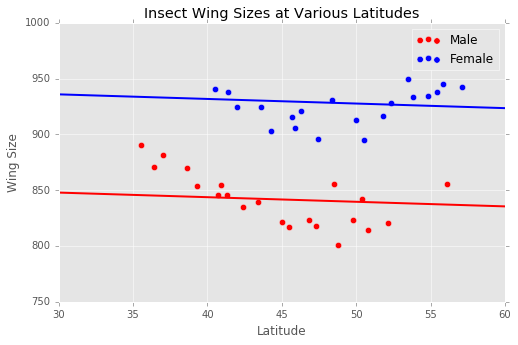

In [14]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
sex_boolean = insects.sex.astype(bool)
ax.scatter(insects.latitude[sex_boolean], 
           insects.wingsize[sex_boolean],
           s=40, c="red", label="Male")
ax.scatter(insects.latitude[~sex_boolean], 
           insects.wingsize[~sex_boolean],
           s=40, c="blue", label="Female")

# Make a linea graph of the predictions.
x = np.linspace(30, 60, num=250)
ax.plot(x, insects_model_with_sex.params[0] 
             + insects_model_with_sex.params[1] * x,
       linewidth=2, c="blue")
ax.plot(x, insects_model_with_sex.params[0] 
             + insects_model_with_sex.params[1] * x + insects_model_with_sex.params[2],
       linewidth=2, c="red")

ax.set_xlim(30, 60)
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Insect Wing Sizes at Various Latitudes")
ax.legend()

### Accounting for the Curvature of the Data Points

We can account for the curvature of the data points by using a *poynomial regression*.  This means that we fit powers of latitude bigger than one:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} $$

In [15]:
linear_model = smf.ols(formula='wingsize ~ latitude + I(latitude**2) + sex', data=insects)
insects_model_quad = linear_model.fit()
linear_model_summary(insects_model_quad)

              Linear Model Summary             
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept               1946.89           91.87
latitude                 -43.21            3.89
I(latitude ** 2)           0.45            0.04
sex                      -89.46            3.81


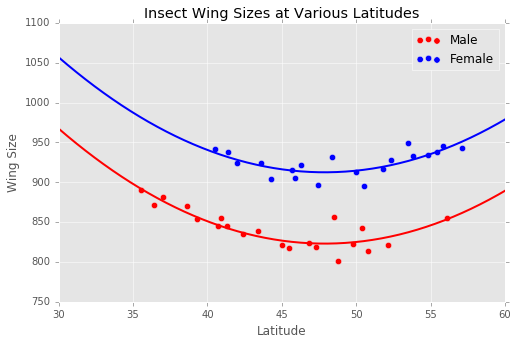

In [16]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
sex_boolean = insects.sex.astype(bool)
ax.scatter(insects.latitude[sex_boolean], 
           insects.wingsize[sex_boolean],
           s=40, c="red", label="Male")
ax.scatter(insects.latitude[~sex_boolean], 
           insects.wingsize[~sex_boolean],
           s=40, c="blue", label="Female")

# Make a linea graph of the predictions.
x = np.linspace(30, 60, num=250)
ax.plot(x, insects_model_quad.params[0] 
             + insects_model_quad.params[1] * x
             + insects_model_quad.params[2] * x*x,
       linewidth=2, c="blue")
ax.plot(x, insects_model_quad.params[0] 
             + insects_model_quad.params[1] * x
             + insects_model_quad.params[2] * x*x
             + insects_model_quad.params[3],
       linewidth=2, c="red")

ax.set_xlim(30, 60)
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Insect Wing Sizes at Various Latitudes")
ax.legend()

## Logistic Regression

In linear regression we want to predict some quantity that has a continuous range of values.

*Logistic Regression* solves a slightly different problem.  What if we flip our dataset around, and want to predict the sex of an insect from the other measurements?

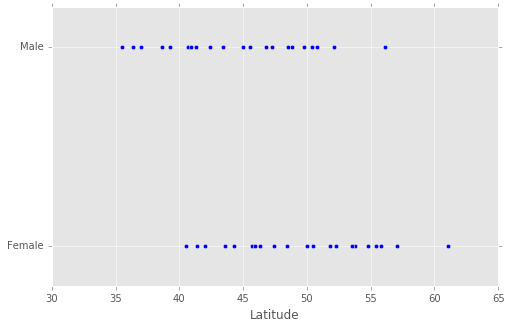

In [17]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
ax.scatter(insects.latitude, insects.sex)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Female', 'Male'])
ax.set_xlabel("Latitude")

Logistic regression does *not* attempt to predict the exact value of $y$ (in this case, whether an insect is male or female).  Instead, it attempts to estiamte the probability that an insect is male or female.

$$ P(\text{Insect is Female} \mid \text{Latitude}) $$

In [18]:
logistic_model = smf.logit(formula='sex ~ latitude',
                           data=insects)
insects_model_logistic = logistic_model.fit(disp=0)
linear_model_summary(insects_model_logistic)

              Linear Model Summary             
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept                  7.30            2.97
latitude                  -0.16            0.06


Logistic regression attempts to draw a *curve* of predicted probabilities (not a line, as in linear regression).

The above logistic regression results in the following curve:

$$ P(\text{Insect is Female} \mid \text{Latitude}) = \frac{1}{1 + e^{-7.3 + 0.16 \times \text{Latitude}}} $$

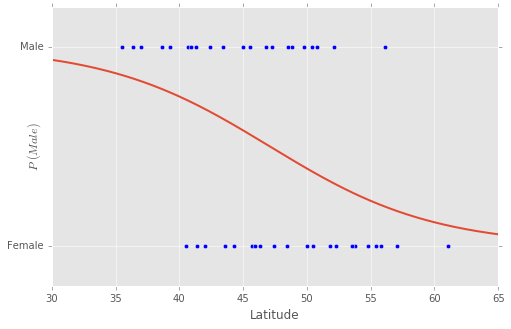

In [19]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
ax.scatter(insects.latitude, insects.sex)

x = pd.DataFrame({'latitude': np.linspace(30, 65, num=250)})
ax.plot(x, insects_model_logistic.predict(x), linewidth=2)

ax.set_xlim([30, 65])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Female', 'Male'])
ax.set_xlabel("Latitude")
ax.set_ylabel(r"$P \ (Male)$")
ax.yaxis.set_label_coords(-0.02, 0.5)

What if we need to make a binary decision, i.e. we need to use the estimated probabilities to acctually classify each insect as either male or female?

We can accomplish this by thresholding probabilities:

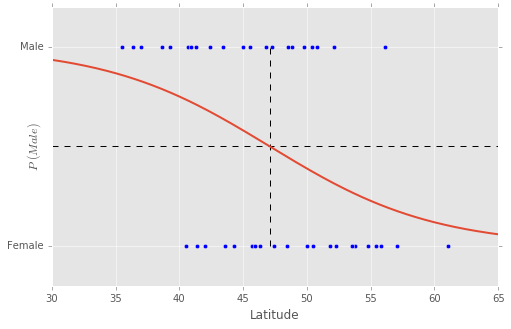

In [34]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
ax.scatter(insects.latitude, insects.sex)

x = pd.DataFrame({'latitude': np.linspace(30, 65, num=250)})
ax.plot((30, 65), (0.5, 0.5), color="black", linestyle="--")
ax.plot((47.075, 47.075), (0, 1), color="black", linestyle="--")
ax.plot(x, insects_model_logistic.predict(x), linewidth=2)

ax.set_xlim([30, 65])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Female', 'Male'])
ax.set_xlabel("Latitude")
ax.set_ylabel(r"$P \ (Male)$")
ax.yaxis.set_label_coords(-0.02, 0.5)

Here we threshold the probabilities at $0.5$, which divides the data into insects we predict are male and insects we predict are positive.

Some datapoints are predicted incorrectly, these come in two types:

  - **False Positives**: Insects we predict are in the positive class (Male in this case, an arbitrary decision), which we are incorrect about (they are actually female).
  - **False Negatives**: Insects we predict are in the negative class (Female in this case), but incorrectly (they are actually Male).